# Honey Bee - Data Exploration & Model Training

Let's think about some Bee🐝autiful things in the world such as honey bees and the orchestration of their daily routines in the hexagonal structures. 
> ⚠️ **This exercise is not completed and may contain several problems that need to be corrected.**

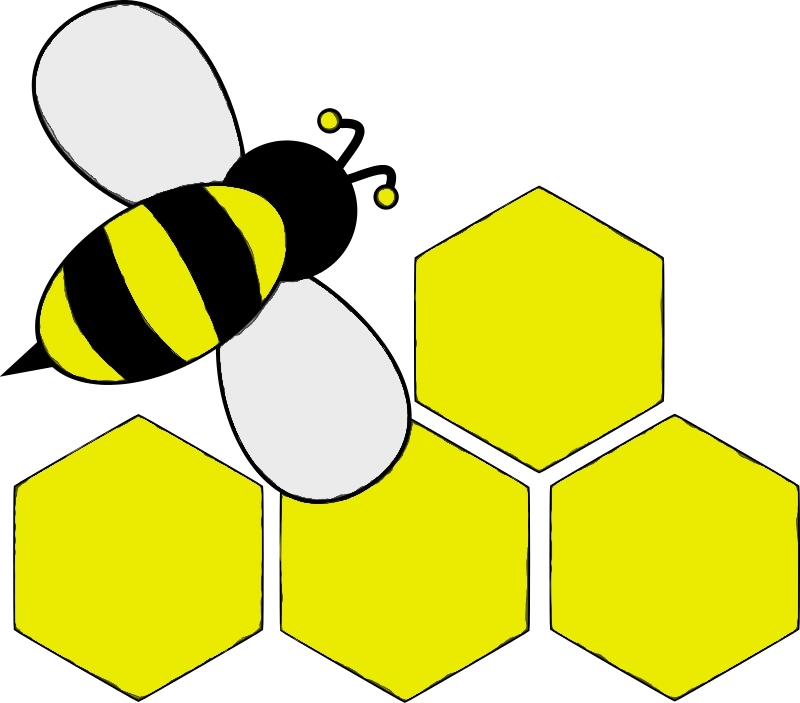

This exercise contains step by step data exploration and fine-tuning `VGG-16` model on a small dataset `Annotated Honey Bee Image Dataset`. 
This dataset comprises over 5,100 bee images. Each bee is annotated with details like location, date, time, subspecies, health status, caste, and pollen presence. The images originated from time-lapse videos capturing of bees. Each frame of the video is subtracted against the background to bring out the bees in the forefront. Each image of the dataset contains only one bee. The quality of the images is influenced by the video quality and how they are cropped.

>**Side Note:** If you want to know why hexagons are interesting, just watch the video <a href="https://youtu.be/thOifuHs6eY" target="_blank">hexagons are bestagons</a>.



The steps we are taking are as following:<br>
<a href='#1'>1. Install and import the required packages</a><br>
<a href='#2'>2. Loading and exploring data</a><br>
<a href='#3'>3. Finetuning</a><br>
<a href='#4'>4. Inference</a><br>

**Bee 🐝 happy** 😊 & move on

# <p id='1' > 1. Install and import the required packages<p>

In [1]:
!pip install pandas numpy scikit-learn torch

In [60]:
!pip install -U  

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms, utils, models
import sys
import os
import random
from pathlib import Path
import copy
from PIL import Image
import imageio
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.io as pio
pio.renderers.default = 'png'
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import time
import warnings
warnings.filterwarnings("ignore")
import folium
from folium.plugins import HeatMap
from geopy.geocoders import ArcGIS

In [4]:
path_config = {
    'csv_path': '/kaggle/input/honey-bee-annotated-images/bee_data.csv',
    'image_path': '/kaggle/input/honey-bee-annotated-images/bee_imgs/bee_imgs/',
}

# <p id='2'>2. Loading and exploring data</p>

In [5]:
honey_bee_df = pd.read_csv(path_config['csv_path'])

The dataset comprises 5172 rows and 9 columns.

In [6]:
honey_bee_df.shape

(5172, 9)

To gain a glimpse into the dataset's content, we sample 100 rows and display the first 10:

In [7]:
honey_bee_df.sample(100).head(10)

file     date   time              location  zip code  \
188    017_036.png   8/6/18  13:21     Saratoga, CA, USA     95070   
4699  019_1225.png   8/6/18  19:19     Saratoga, CA, USA     95070   
4898  019_1049.png   8/6/18  19:19     Saratoga, CA, USA     95070   
4913  019_1314.png   8/6/18  19:19     Saratoga, CA, USA     95070   
2724   010_725.png  8/19/18  12:46   Des Moines, IA, USA     50315   
606    008_294.png  8/16/18   8:20  New Orleans, LA, USA     70115   
1616   040_015.png  8/21/18  15:56       Athens, GA, USA     30607   
1995   016_039.png  8/20/18  11:55     San Jose, CA, USA     95124   
3621  015_1264.png   8/6/18  13:19     Saratoga, CA, USA     95070   
4446   038_468.png  8/18/18  12:30  Athens, Georgia, USA     30607   

                 subspecies                      health  pollen_carrying  \
188       Italian honey bee                     healthy            False   
4699      Italian honey bee                     healthy            False   
4898      Italian honey bee                     healthy            False   
4913      Italian honey bee                     healthy            False   
2724    Carniolan honey bee                     healthy            False   
606   VSH Italian honey bee                     healthy            False   
1616      Italian honey bee    few varrao, hive beetles            False   
1995                     -1                     healthy            False   
3621      Italian honey bee                     healthy            False   
4446  1 Mixed local stock 2  Varroa, Small Hive Beetles            False   

       caste  
188   worker  
4699  worker  
4898  worker  
4913  worker  
2724  worker  
606   worker  
1616  worker  
1995  worker  
3621  worker  
4446  worker

To check some other aspects of the data such as most frequent values, missing values and unique ones, we first define functions accordingly. 

In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().mean() * 100)
    types = [str(data[col].dtype) for col in data.columns]
    tt = pd.concat([total, percent, pd.Series(types, index=data.columns)], 
                    axis=1, keys=['Total', 'Percent', 'Types'])
    return tt.T

def unique_values(data):
    uniques = [data[col].nunique() for col in data.columns]
    tt = pd.DataFrame({'Total': data.count(), 'Uniques': uniques}).T
    return tt

def most_frequent_values(data):
    items = []
    vals = []
    total = data.count()
    for col in data.columns:
        try:
            value_counts = data[col].value_counts()
            items.append(value_counts.index[0])
            vals.append(value_counts.values[0])
        except IndexError:
            items.append(0)
            vals.append(0)
    tt = pd.DataFrame({'Total': total, 'Most frequent item': items, 'Frequency': vals}).T
    tt.loc['Percent from total'] = np.round(tt.loc['Frequency'] / tt.loc['Total'] * 100, 3)
    return tt


Understanding missing values is crucial for data integrity. We use the function missing_data() to provide insights into the dataset's missing values. The function computes the total count and percentage of missing values in each column.

In [9]:
missing_data(honey_bee_df)

file    date    time location zip code subspecies  health  \
Total         0       0       0        0        0          0       0   
Percent     0.0     0.0     0.0      0.0      0.0        0.0     0.0   
Types    object  object  object   object    int64     object  object   

        pollen_carrying   caste  
Total                 0       0  
Percent             0.0     0.0  
Types              bool  object

The function unique_values() reveals the count of unique values in each column.

In [10]:
unique_values(honey_bee_df)

file  date  time  location  zip code  subspecies  health  \
Total    5172  5172  5172      5172      5172        5172    5172   
Uniques  5172    16    35         8         7           7       6   

         pollen_carrying  caste  
Total               5172   5172  
Uniques                2      1

Using the function most_frequent_values(), we identify the predominant values within each column.

In [11]:
most_frequent_values(honey_bee_df)

file       date       time           location  \
Total                      5172       5172       5172               5172   
Most frequent item  027_014.png    8/21/18      15:56  Saratoga, CA, USA   
Frequency                     1       1080        579               2000   
Percent from total     0.019335  20.881671  11.194896           38.66976   

                    zip code         subspecies     health pollen_carrying  \
Total                   5172               5172       5172            5172   
Most frequent item     95070  Italian honey bee    healthy           False   
Frequency               2000               3008       3384            5154   
Percent from total  38.66976          58.159319  65.429234       99.651972   

                     caste  
Total                 5172  
Most frequent item  worker  
Frequency             5172  
Percent from total   100.0

Next, let's see where those data are collected. This can be applied directly on the pandas dataframe by using the built-in unique() function. 

In [12]:
pd.DataFrame(honey_bee_df['location'].unique())

0
0        Alvin, TX, USA
1     Saratoga, CA, USA
2       Athens, GA, USA
3     San Jose, CA, USA
4  New Orleans, LA, USA
5   Des Moines, IA, USA
6        Keene, NH, USA
7  Athens, Georgia, USA

As we see on the above dataframe, we've got two names for the same location which are Athens, Georgia, USA and Athens, GA, USA. It is better to merge those two together in this step. 

In [13]:
honey_bee_df = honey_bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')

The two duplicate locations are now merged into one. We can count the number of images collected per location in the next step. 

In [14]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

zip code              location  Images
0      3431        Keene, NH, USA      92
1     30607       Athens, GA, USA    1051
2     50315   Des Moines, IA, USA     973
3     70115  New Orleans, LA, USA     170
4     77511        Alvin, TX, USA     737
5     95070     Saratoga, CA, USA    2000
6     95124     San Jose, CA, USA     149

## Visualizing Honey Bee Data: Mapping and Plotting Insights

Utilizing the folium library, we craft an interactive heatmap to visualize where those images are taken from. 

In [15]:
heat_data = []
for loc, count in zip(df["location"], df["Images"]):
    geolocator = ArcGIS()
    location = geolocator.geocode(loc)
    if location:
        if loc == "San Jose, CA, USA":
            lat = location.latitude - 1
            lon = location.longitude + 2
        else:
            lat = location.latitude
            lon = location.longitude
        heat_data.append([lat, lon, count])

# Create map
mymap = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add Marker for each location with popup showing image count
for loc, count in zip(df["location"], df["Images"]):
    geolocator = ArcGIS()
    location = geolocator.geocode(loc)
    if location:
        if loc == "San Jose, CA, USA":
            lat = location.latitude - 1
            lon = location.longitude + 2
        else:
            lat = location.latitude
            lon = location.longitude
        popup = f"""<div style='width: 170px'>
              <b>Location:</b> {loc}<br/>
              <b>Image Count:</b> {count}</div>"""
    folium.Marker(location=[lat, lon], popup=popup).add_to(mymap)

# Add HeatMap layer
HeatMap(heat_data).add_to(mymap)

# Display map
mymap


In the above heatmap, we can clearly see that 2000 images belongs to Saratoga, CA, USA. 

The distribution of honey bee subspecies across various locations could be another interesting aspect. We employ `plotly.express` to create an insightful scatter plot for this purpose.

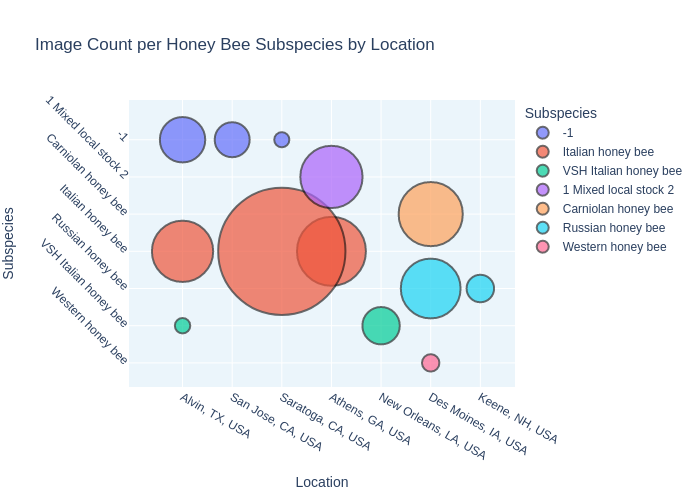

In [16]:
# Group the data by both location and subspecies and count them
location_subspecies_counts = honey_bee_df.groupby(['location', 'subspecies']).size().reset_index(name='count')

fig = px.scatter(location_subspecies_counts, x='location', y='subspecies', size='count', 
                 title='Image Count per Honey Bee Subspecies by Location',
                 labels={'count': 'Count', 'subspecies': 'Subspecies', 'location': 'Location'},
                 size_max=90, color='subspecies')

fig.update_traces(marker=dict(line=dict(color='rgba(0,0,0,0.8)', width=2)))
fig.update_layout(plot_bgcolor="#ebf5fb") 
# Rotate the labels on the vertical axis by 45 degrees
fig.update_yaxes(tickangle=45)

# Set the category order for the health axis to rotate the labels
fig.update_layout(yaxis_categoryorder='category descending')
fig.show()


The above plot illustrates 1972 Carniolan honey bee which belongs to Saratoga, CA, USA as the major count per location. We can confirm that in the following dataframe as well. 

> **Note:** The subspecies **-1** refers to unknown class. 

In [17]:
honey_bee_df.groupby(['location', 'subspecies']).size().reset_index(name='count')

location             subspecies  count
0         Alvin, TX, USA                     -1    251
1         Alvin, TX, USA      Italian honey bee    457
2         Alvin, TX, USA  VSH Italian honey bee     29
3        Athens, GA, USA  1 Mixed local stock 2    472
4        Athens, GA, USA      Italian honey bee    579
5    Des Moines, IA, USA    Carniolan honey bee    501
6    Des Moines, IA, USA      Russian honey bee    435
7    Des Moines, IA, USA      Western honey bee     37
8         Keene, NH, USA      Russian honey bee     92
9   New Orleans, LA, USA  VSH Italian honey bee    170
10     San Jose, CA, USA                     -1    149
11     Saratoga, CA, USA                     -1     28
12     Saratoga, CA, USA      Italian honey bee   1972

One of the most important aspects in data exploration is the class distribution within the dataset. Ideally the frequencies of the classes should be equal, but that is not the case in real world.

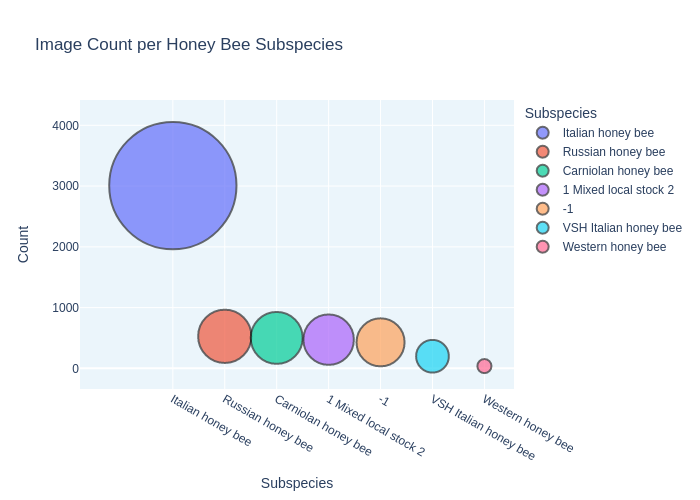

In [18]:
# Get the unique subspecies and count them
subspecies_counts = honey_bee_df['subspecies'].value_counts().reset_index()
subspecies_counts.columns = ['subspecies', 'count']

fig = px.scatter(subspecies_counts, x='subspecies', y='count', size='count', 
                 title='Image Count per Honey Bee Subspecies',
                 labels={'count': 'Count', 'subspecies': 'Subspecies'},
                 size_max=90, color='subspecies')

fig.update_traces(marker=dict(line=dict(color='rgba(0,0,0,0.8)', width=2)))
fig.update_layout(plot_bgcolor="#ebf5fb")  
fig.show()

The class distribution seems to be pretty imbalanced in the above illustration. The italian honey bee represents the clear majority over other subspecies. The following dataframe confirm that as well.

In [19]:
pd.DataFrame(honey_bee_df['subspecies'].value_counts())

count
subspecies                  
Italian honey bee       3008
Russian honey bee        527
Carniolan honey bee      501
1 Mixed local stock 2    472
-1                       428
VSH Italian honey bee    199
Western honey bee         37

**Loading images**

Now, it's time to load images. 
As shown in the following, there are totally 5172 images within the dataset. 

In [20]:
len(list(os.listdir(path_config['image_path'])))

5172

The next thing wee need to know is the shape of each image. The following function reads each image and returns its shape. 

In [21]:
# Reads images from the given path and returns their shapes
def read_image_sizes_cv(file_name):
    image = cv2.imread(path_config['image_path']+file_name)
    return list(image.shape)

image_shapes=honey_bee_df['file'].head(5).apply(read_image_sizes_cv).apply(pd.Series)
image_shapes.columns=['Width', 'Height', 'Channel']
image_shapes

Width  Height  Channel
0    115     164        3
1    201      90        3
2    132     167        3
3    134      97        3
4    147     106        3

We then use the above function to add image sizes to the dataframe as the following. 

In [22]:
img_shapes = np.stack(honey_bee_df['file'].apply(read_image_sizes_cv))
shapes_df = pd.DataFrame(img_shapes, columns=['width', 'height', 'channel'])

# Check if columns already exist
existing_cols = set(shapes_df.columns).intersection(set(honey_bee_df.columns))

# Add columns only if they don't exist
if not all(col in existing_cols for col in ['width', 'height', 'channel']):
    honey_bee_df = pd.concat([honey_bee_df, shapes_df], axis=1, sort=False)

honey_bee_df.head()

file     date   time        location  zip code subspecies  \
0  041_066.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
1  041_072.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
2  041_073.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
3  041_067.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   
4  041_059.png  8/28/18  16:07  Alvin, TX, USA     77511         -1   

              health  pollen_carrying   caste  width  height  channel  
0  hive being robbed            False  worker    115     164        3  
1  hive being robbed            False  worker    201      90        3  
2  hive being robbed            False  worker    132     167        3  
3  hive being robbed            False  worker    134      97        3  
4  hive being robbed            False  worker    147     106        3

Let's check how the images look like by showing 7 examples of each subspecies in a row. 

In [23]:
def show_images(var, rows=3, cols=5):
    cats = honey_bee_df[var].unique()[:rows]
    f, ax = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    for i, cat in enumerate(cats):
        samples = honey_bee_df[honey_bee_df[var] == cat].sample(cols)
        for j, (_, sample) in enumerate(samples.iterrows()):
            im = imageio.imread(path_config['image_path'] + sample['file'])
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)
    plt.tight_layout()
    plt.show()

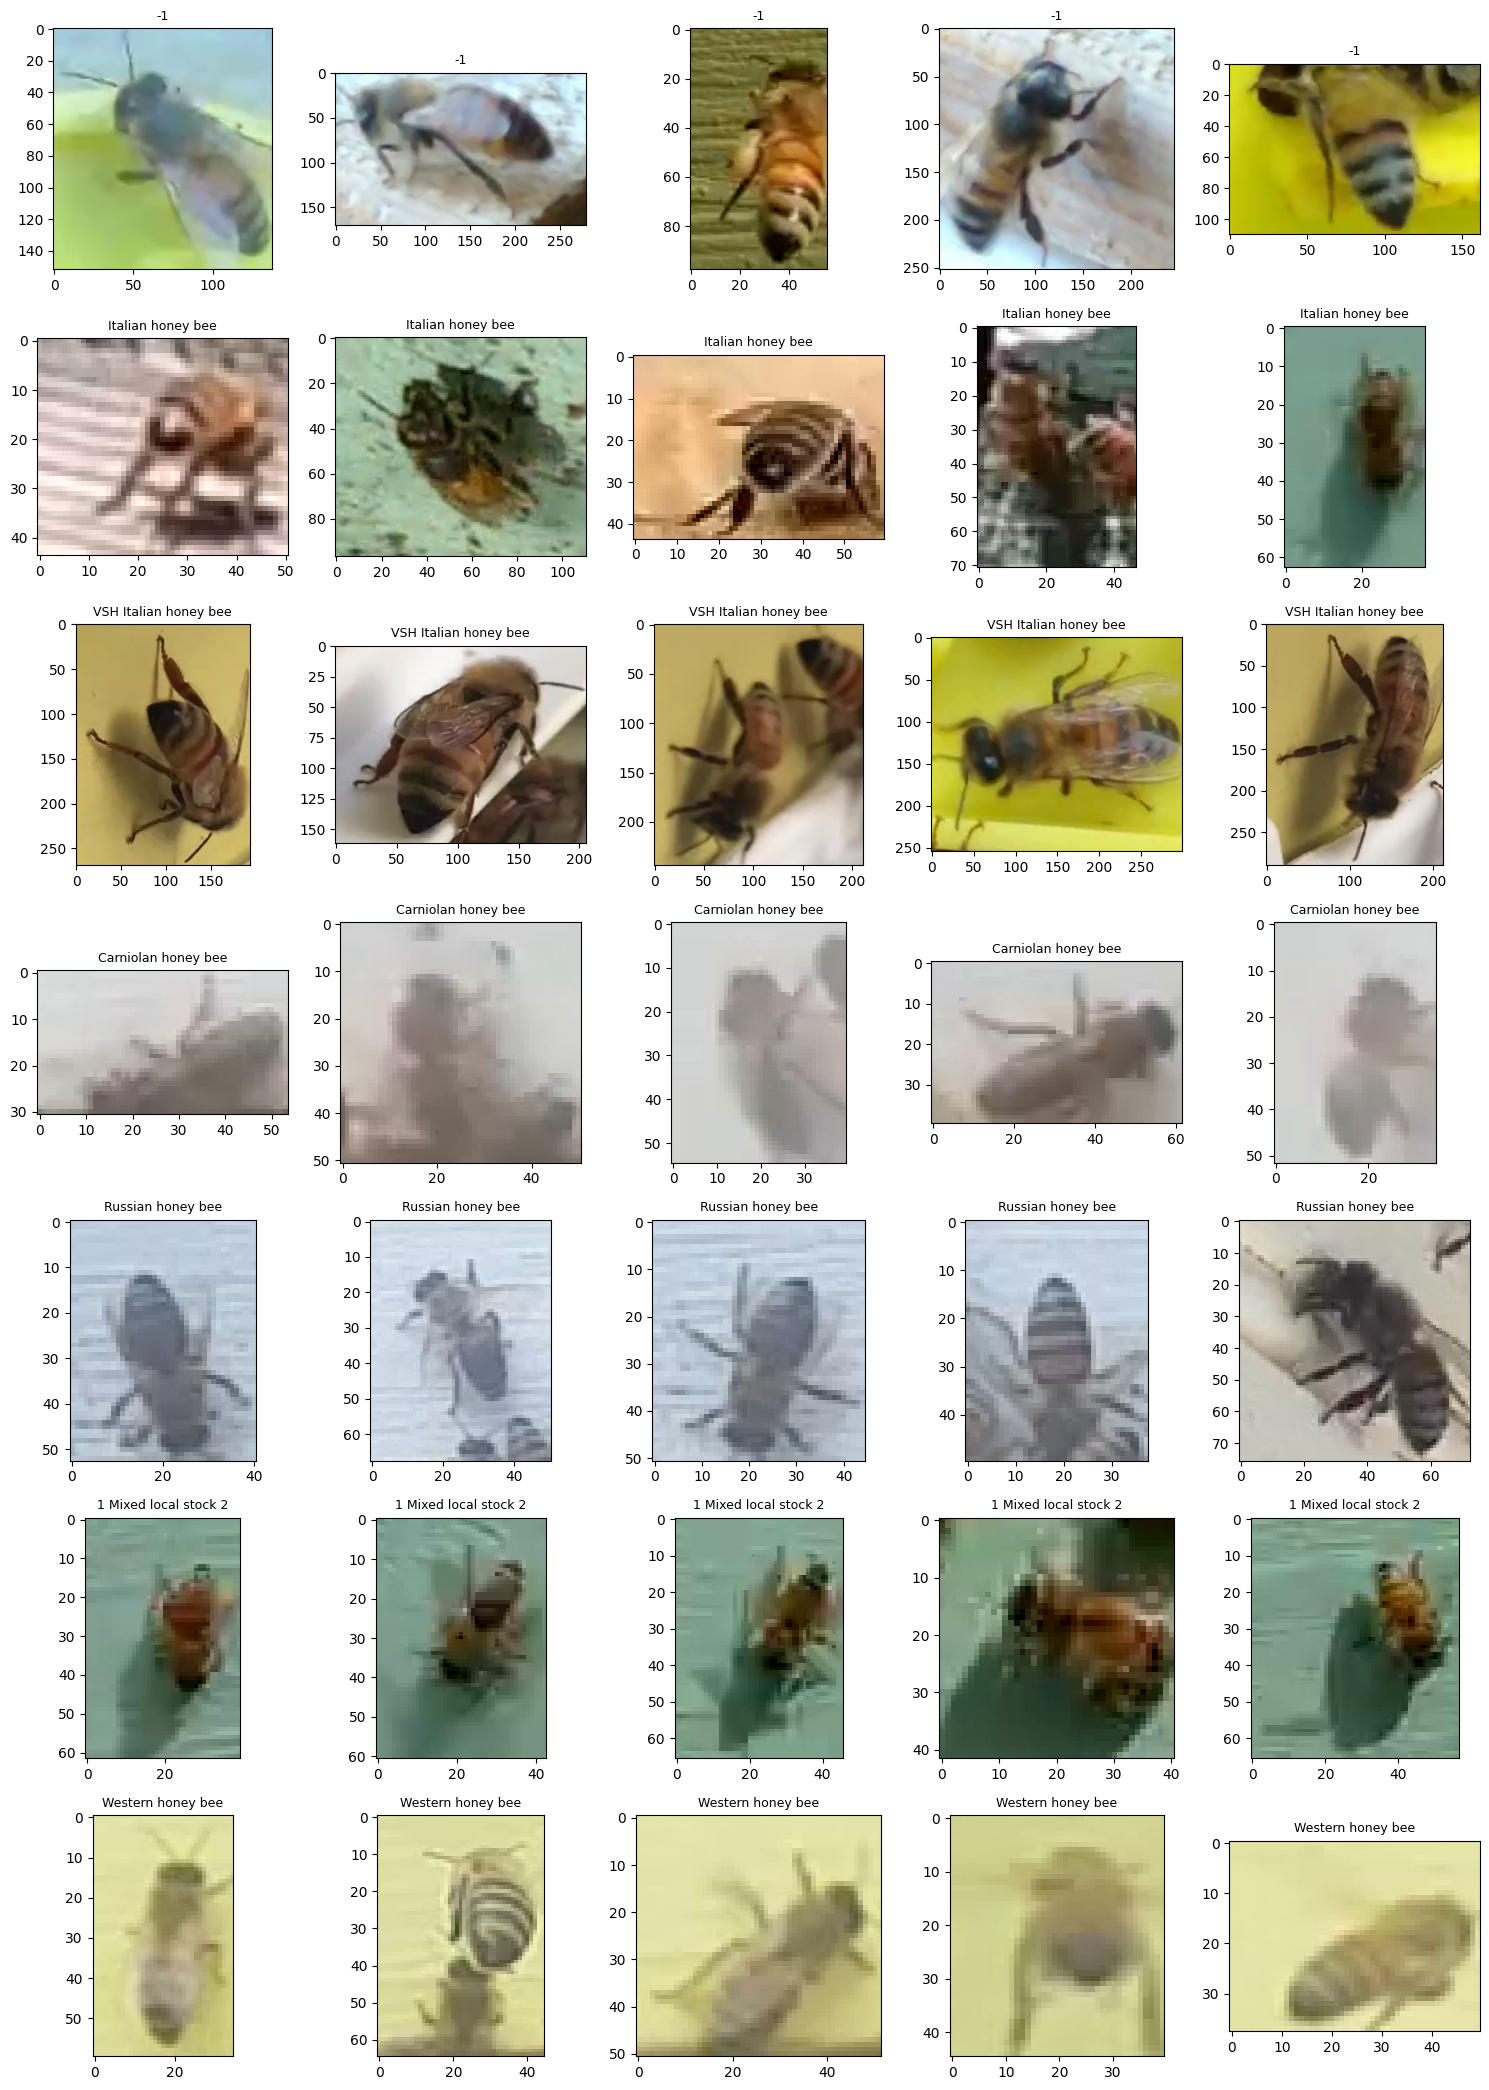

In [24]:
show_images("subspecies", rows=7)

Here we can clearly see that the images are of low quality since they are being cropped from certain frames of videos. Furthermore, some images share the same background as they belongs to a one single hive in a video. This can be problematic for the model to capture the useful relevant representation of the data.   

**Image Size**<br />
Another important aspect is the size of images. Since I want to fine-tune the VGG 16 model on the data, understanding the dimensions of the images plays a crucial role for data augmentation and compatibility with respect to the model configuration. To better grasp the dimensions of the images, we can visualize their width and height distributions using box plots.

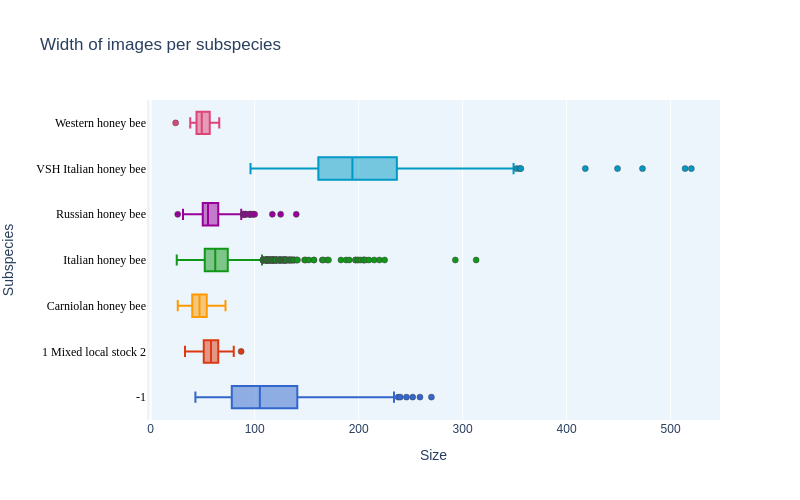

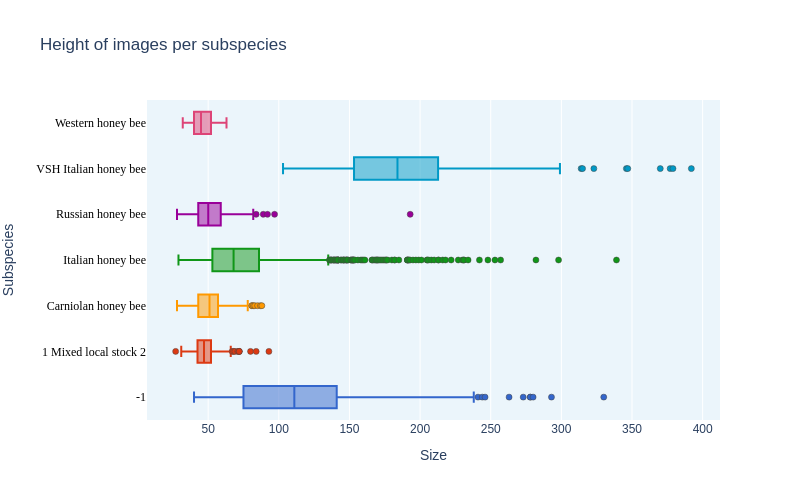

In [25]:
def draw_trace_box(dataset, var, subspecies):
    dfS = dataset[dataset['subspecies'] == subspecies]
    trace = go.Box(
        x=dfS[var],
        name=subspecies,
        marker=dict(
            color='rgba(0, 0, 255, 0.5)',  # Set a default color
            line=dict(
                width=0.5
            ),
        ),
        text=dfS['subspecies'],
        orientation='h'
    )
    return trace

subspecies = (honey_bee_df.groupby(['subspecies'])['subspecies'].nunique()).index
colors = px.colors.qualitative.G10  # Using a predefined qualitative color scale

def draw_group(dataset, var, title, height=500):
    data = []
    for i, subs in enumerate(subspecies):
        data.append(draw_trace_box(dataset, var, subs))
        data[-1]['marker']['color'] = colors[i % len(colors)]  # Assigning colors from the color scale
        
    layout = dict(
        title=title,
        xaxis=dict(title='Size', showticklabels=True),
        yaxis=dict(
            title='Subspecies',
            showticklabels=True,
            tickfont=dict(family='Old Standard TT, serif', size=12, color='black'),
        ),
        hovermode='closest',
        showlegend=False,
        width=800,
        height=height,
        plot_bgcolor="#ebf5fb",
    )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='subspecies-image')

draw_group(honey_bee_df, 'width', "Width of images per subspecies")
draw_group(honey_bee_df, 'height', "Height of images per subspecies")


The above plot illustrates a large variety of weights and heights among subspecies. We can clearly see that the Carniolan honey bee has the smallest weights and heights compared to the VSH Italian honey bee. The Carniolan honey bee has a compact distribution with a median height of 51 and a median width of 47, whereas the VSH Italian honey bee has a median height of 184 and a median width of 194. Let's visualize the comparison between these two mentioned subspecies in a separate hexagonal style (honey bee style😉) plot. 

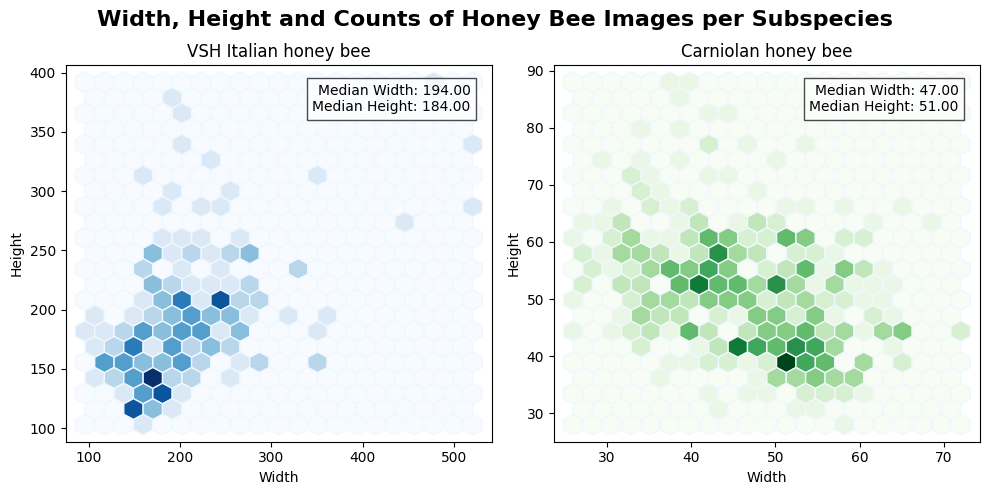

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))  # Adjust figsize if needed
axes = axes.flatten()

cmaps = ['Blues', 'Greens']
labels = ['VSH Italian honey bee', 'Carniolan honey bee']

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    subset = honey_bee_df[honey_bee_df['subspecies'] == label]
    axes[i].hexbin(subset["width"], subset["height"], cmap=cmap,
                   gridsize=20, edgecolors='aliceblue')  # 'k' represents black color for the borders
    axes[i].set_title(label)
    
    # Calculate mean width and height
    mean_width = subset["width"].median()
    mean_height = subset["height"].median()
    
    # Display mean values in the plot
    axes[i].text(0.95, 0.95, f"Median Width: {mean_width:.2f}\nMedian Height: {mean_height:.2f}",
                 transform=axes[i].transAxes, ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # Add labels for width and height
    axes[i].set_xlabel("Width")
    axes[i].set_ylabel("Height")

plt.tight_layout()
plt.suptitle("Width, Height and Counts of Honey Bee Images per Subspecies", fontsize=16, fontweight="bold")
plt.subplots_adjust(top=0.87)
plt.show()


We can clearly see how shapes of images related to the above two subspecies vary in our dataset. Now, its time to plot the sizes of all the subspecies at once. 

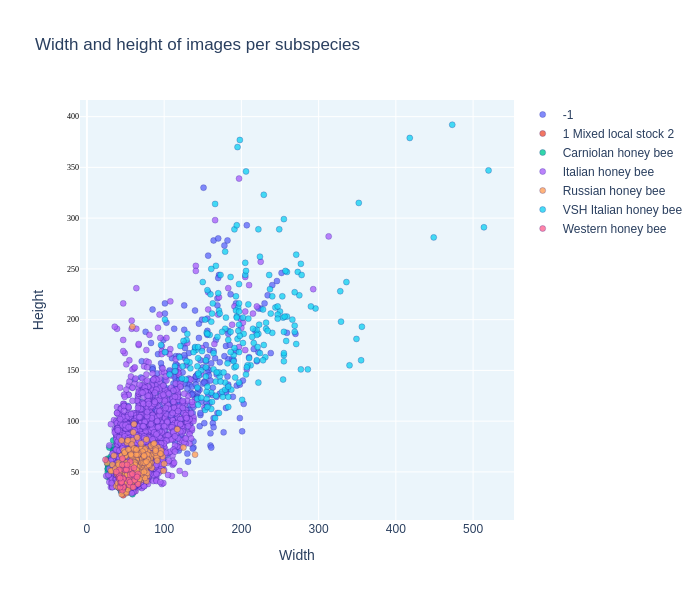

In [27]:
def draw_group(dataset, title, height=600):
    subspecies = dataset['subspecies'].unique()
    data = [go.Scatter(
                x=df['width'],
                y=df['height'],
                name=sub,
                mode="markers",
                marker=dict(opacity=0.8, line=dict(width=0.3, color='navy')),
                text=df['subspecies']
            ) for sub, df in dataset.groupby('subspecies')]
    
    layout = dict(
        title=title,
        xaxis=dict(title='Width', showticklabels=True),
        yaxis=dict(title='Height', showticklabels=True, tickfont=dict(
            family='Old Standard TT, serif',
            size=8,
            color='black'),),
        hovermode='closest',
        showlegend=True,
        height=height,
        plot_bgcolor="#ebf5fb",
    )
    
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='subspecies-image')

draw_group(honey_bee_df, "Width and height of images per subspecies")

Again, the above image confirms our understanding of size distributions of images with respect to each subspecies. The Carniolan honey bee has highest values regarding width  and height, whereas some other species present more compact distribution. 

In [28]:
width_median = honey_bee_df['width'].median()
height_median = honey_bee_df['height'].median()

print("Median width:", width_median)
print("Median height:", height_median)

Median width: 61.0
Median height: 62.0


In [29]:
width_mean = honey_bee_df['width'].mean()
height_mean = honey_bee_df['height'].mean()

print("Mean width:", width_mean)
print("Mean height:", height_mean)

Mean width: 72.00676720804331
Mean height: 74.4224671307038


**Exploring and Visualizing Honey Bee Health Data**

In this step, we’ll comprehend the honey bee health data. This is crucial for training a model to predict the health of honey bees. Understanding and visualizing the data helps us grasp the patterns and relationships within it. Let's dive into the steps involved.

First, we need to access the health data from our DataFrame honey_bee_df:

In [30]:
honey_bee_df['health']

0       hive being robbed
1       hive being robbed
2       hive being robbed
3       hive being robbed
4       hive being robbed
              ...        
5167              healthy
5168              healthy
5169              healthy
5170              healthy
5171              healthy
Name: health, Length: 5172, dtype: object

Next, we group the data by 'location' and 'subspecies' to count the occurrences of each health status. 

In [31]:
tmp_data = honey_bee_df.groupby(['location', 'subspecies'])['health'].value_counts()
new_df = pd.DataFrame(tmp_data).reset_index()
new_df = new_df.sort_values('location')
new_df

location             subspecies                      health  \
0         Alvin, TX, USA                     -1           hive being robbed   
1         Alvin, TX, USA      Italian honey bee                ant problems   
2         Alvin, TX, USA  VSH Italian honey bee               missing queen   
3        Athens, GA, USA  1 Mixed local stock 2  Varroa, Small Hive Beetles   
4        Athens, GA, USA      Italian honey bee    few varrao, hive beetles   
5    Des Moines, IA, USA    Carniolan honey bee                     healthy   
6    Des Moines, IA, USA      Russian honey bee                     healthy   
7    Des Moines, IA, USA      Western honey bee                     healthy   
8         Keene, NH, USA      Russian honey bee                     healthy   
9   New Orleans, LA, USA  VSH Italian honey bee                     healthy   
10     San Jose, CA, USA                     -1                     healthy   
11     Saratoga, CA, USA                     -1                     healthy   
12     Saratoga, CA, USA      Italian honey bee                     healthy   

    count  
0     251  
1     457  
2      29  
3     472  
4     579  
5     501  
6     435  
7      37  
8      92  
9     170  
10    149  
11     28  
12   1972

We further group the data by 'health' and 'subspecies' to count the images.

In [32]:
tmp = honey_bee_df.groupby(['health'])['subspecies'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

health             subspecies  Images
0   Varroa, Small Hive Beetles  1 Mixed local stock 2     472
1                 ant problems      Italian honey bee     457
2     few varrao, hive beetles      Italian honey bee     579
3                      healthy      Italian honey bee    1972
4                      healthy      Russian honey bee     527
5                      healthy    Carniolan honey bee     501
6                      healthy                     -1     177
7                      healthy  VSH Italian honey bee     170
8                      healthy      Western honey bee      37
9            hive being robbed                     -1     251
10               missing queen  VSH Italian honey bee      29

Now, it's time to present the number of bee images per location, health, and subspecies in a scatter plot. 

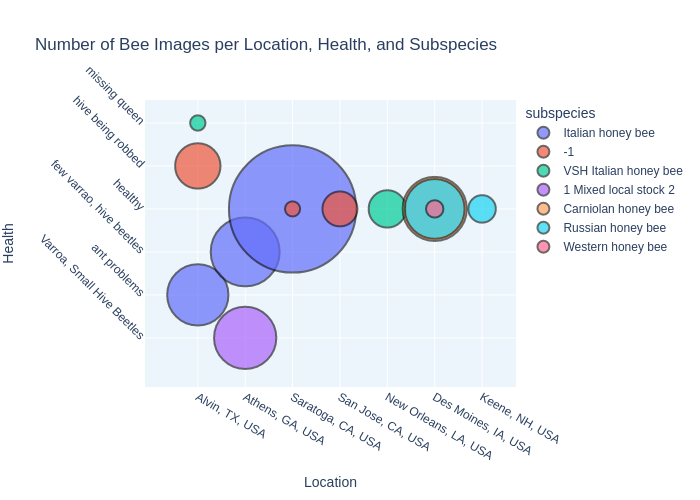

In [33]:
# Group the data by location, health, and subspecies and count the images
location_health_subspecies_counts = honey_bee_df.groupby(['location', 'health', 'subspecies']).size().reset_index(name='count')

fig = px.scatter(location_health_subspecies_counts, x='location', y='health', size='count', 
                 title='Number of Bee Images per Location, Health, and Subspecies',
                 labels={'count': 'Count', 'health': 'Health', 'location': 'Location'},
                 size_max=90, color='subspecies')

fig.update_traces(marker=dict(line=dict(color='rgba(0,0,0,0.8)', width=2)))
fig.update_layout(plot_bgcolor="#ebf5fb") 
fig.update_yaxes(tickangle=45)

# Set the category order for the health axis to rotate the labels
fig.update_layout(yaxis_categoryorder='category ascending')

fig.show()


The above plot presents that the major healthy subspecies belongs to Italian honey bee with a count of 1972 being collected in Saratoga, CA, USA. We also notice that some health problems are dominantly present in one location, whereas the location Saratoga, CA, USA provided us only bees which are healthy. 

Let's take a look at the images of the bees with respect to their health status. 

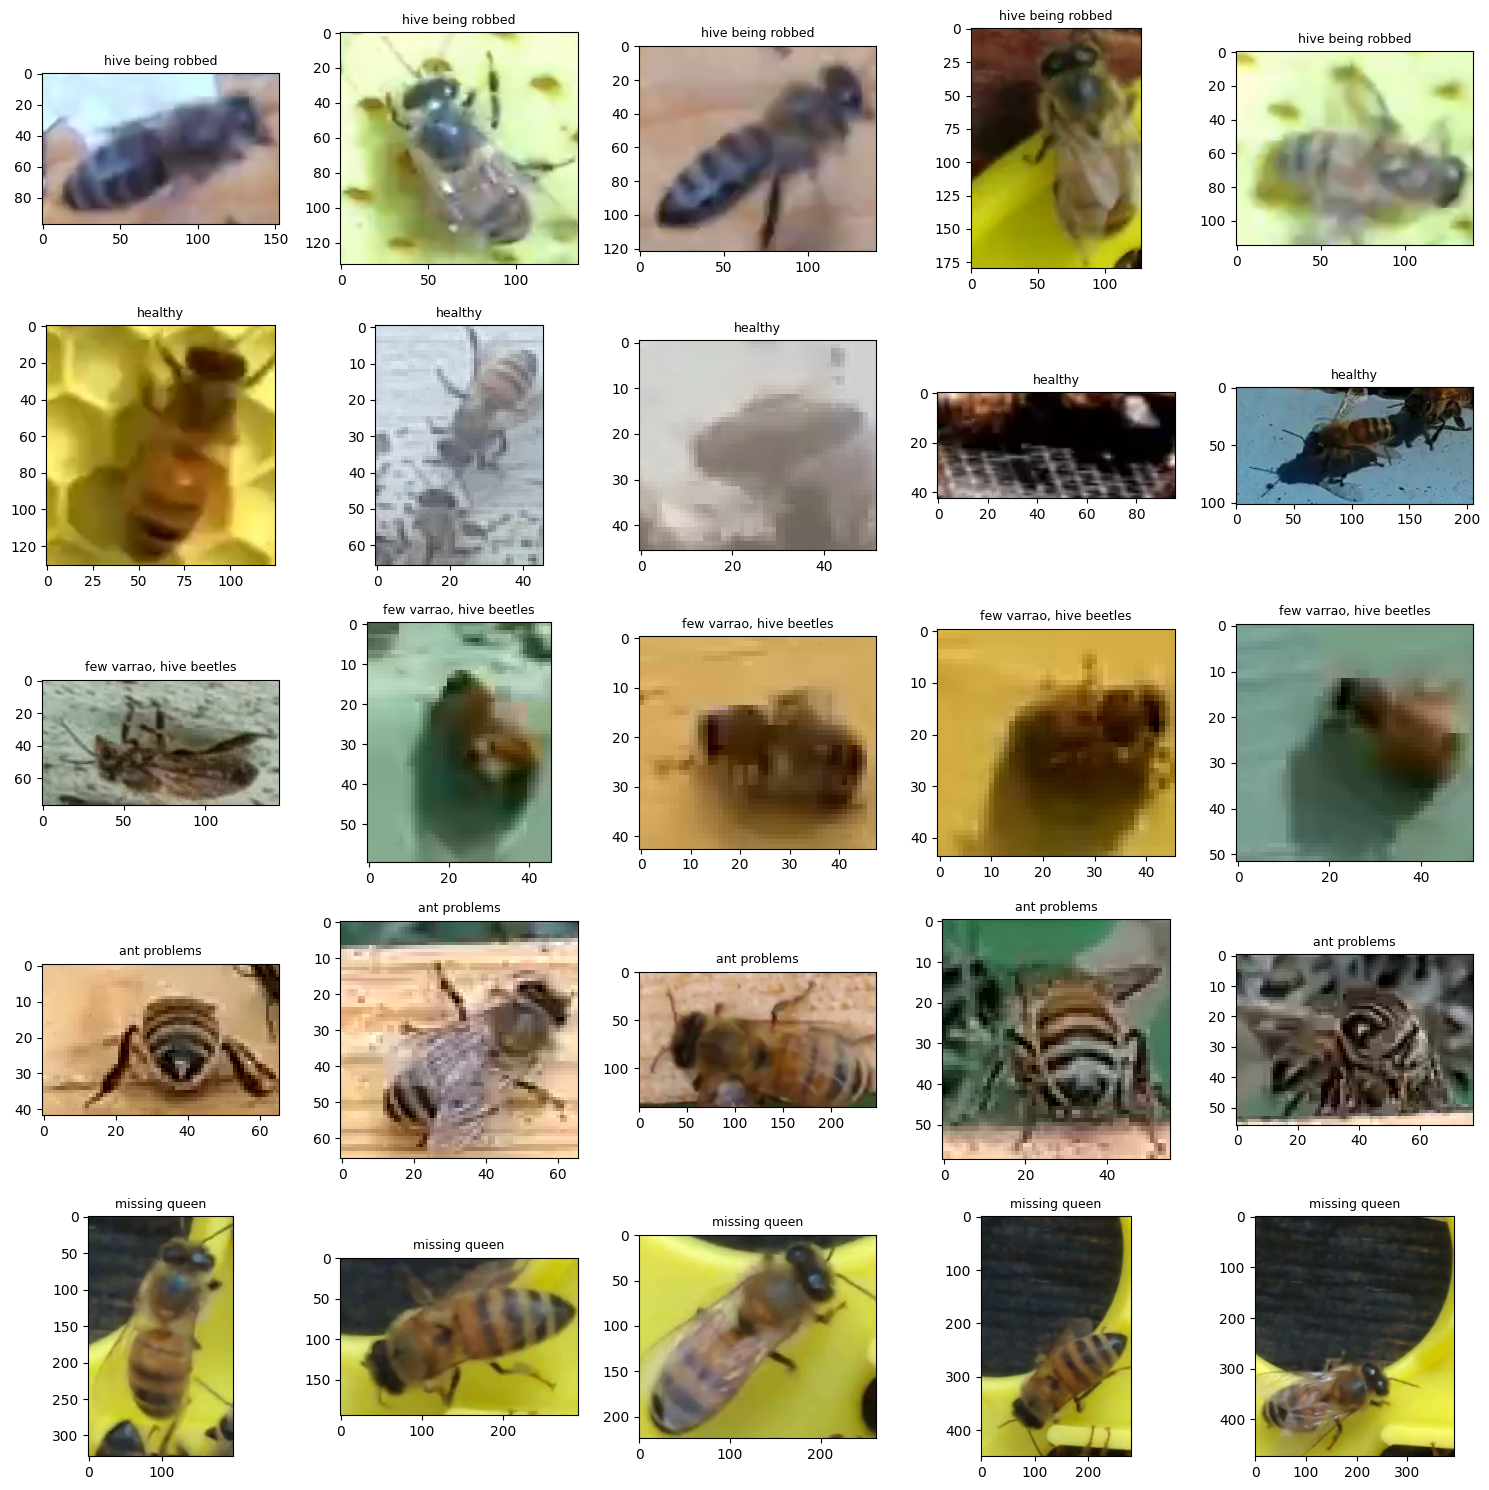

In [34]:
show_images('health', rows=5)

Here we see that some health problems refers to a single hive with distinct background, leading the model to potentially capture unrelevant background feature during training process. We may partially avoid this by data augmentation first, and then check the result after the training process by a method of explainability. But for now, we go further. 

**Conclusion**

To have glance at our dataset at once, I like to use plotly_sankey for visualization of the data in an interesting way. In the following, we have a function for plotting and a dataframe for confirmation of the plot information. 

In [35]:
def plotly_sankey(df, cat_cols=[], value_cols='', title='Sankey Diagram', color_palette=None, height=None):
    label_list = list(dict.fromkeys(sum((list(set(df[col])) for col in cat_cols), [])))
    color_list = sum(([color_palette[i]] * len(set(df[col])) for i, col in enumerate(cat_cols)), [])
    
    source_target_df = pd.concat(
        [df[[cat_cols[i], cat_cols[i + 1], value_cols]].rename(columns={cat_cols[i]: 'source', cat_cols[i + 1]: 'target', value_cols: 'count'})
         for i in range(len(cat_cols) - 1)]
    ).groupby(['source', 'target']).agg({'count': 'sum'}).reset_index()

    source_target_df['sourceID'] = source_target_df['source'].apply(label_list.index)
    source_target_df['targetID'] = source_target_df['target'].apply(label_list.index)

    fig = dict(data=[dict(type='sankey',
                          node=dict(pad=15, thickness=20, line=dict(color='black', width=0.5),
                                    label=label_list, color=color_list),
                          link=dict(source=source_target_df['sourceID'], target=source_target_df['targetID'], value=source_target_df['count']))],
               layout=dict(title=title, font=dict(size=10), height=height))
    return fig


In [36]:
tmp = honey_bee_df.groupby(['location', 'zip code', 'date', 'time', 'health'])['subspecies'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

location  zip code     date   time  \
0         Alvin, TX, USA     77511  8/17/18  17:50   
1         Alvin, TX, USA     77511  8/18/18  12:36   
2         Alvin, TX, USA     77511  8/21/18  13:49   
3         Alvin, TX, USA     77511  8/28/18  10:53   
4         Alvin, TX, USA     77511  8/28/18  16:07   
5         Alvin, TX, USA     77511  8/28/18   9:54   
6         Alvin, TX, USA     77511   9/8/18  16:08   
7        Athens, GA, USA     30607  8/18/18  12:30   
8        Athens, GA, USA     30607  8/21/18  15:56   
9    Des Moines, IA, USA     50315  8/19/18  12:46   
10   Des Moines, IA, USA     50315  8/19/18  15:46   
11   Des Moines, IA, USA     50315  8/19/18  18:30   
12   Des Moines, IA, USA     50315  8/21/18   9:00   
13   Des Moines, IA, USA     50315  8/21/18   9:30   
14        Keene, NH, USA      3431  8/25/18  14:00   
15  New Orleans, LA, USA     70115  8/16/18   8:20   
16     San Jose, CA, USA     95124  8/20/18  10:03   
17     San Jose, CA, USA     95124  8/20/18  11:55   
18     San Jose, CA, USA     95124  8/20/18   9:47   
19     San Jose, CA, USA     95124  8/20/18   9:53   
20     Saratoga, CA, USA     95070   7/2/18  13:57   
21     Saratoga, CA, USA     95070   7/2/18  15:30   
22     Saratoga, CA, USA     95070   7/3/18  16:10   
23     Saratoga, CA, USA     95070   7/7/18  12:56   
24     Saratoga, CA, USA     95070   7/7/18  14:00   
25     Saratoga, CA, USA     95070   7/7/18  14:35   
26     Saratoga, CA, USA     95070  8/10/18  13:54   
27     Saratoga, CA, USA     95070  8/13/18  11:00   
28     Saratoga, CA, USA     95070  8/13/18  11:11   
29     Saratoga, CA, USA     95070  8/13/18  11:20   
30     Saratoga, CA, USA     95070   8/6/18  11:25   
31     Saratoga, CA, USA     95070   8/6/18  13:19   
32     Saratoga, CA, USA     95070   8/6/18  13:21   
33     Saratoga, CA, USA     95070   8/6/18  14:48   
34     Saratoga, CA, USA     95070   8/6/18  19:19   
35     Saratoga, CA, USA     95070   8/8/18  21:13   

                        health             subspecies  Images  
0                 ant problems      Italian honey bee     433  
1                 ant problems      Italian honey bee      24  
2                missing queen  VSH Italian honey bee      29  
3            hive being robbed                     -1      28  
4            hive being robbed                     -1     181  
5            hive being robbed                     -1      19  
6            hive being robbed                     -1      23  
7   Varroa, Small Hive Beetles  1 Mixed local stock 2     472  
8     few varrao, hive beetles      Italian honey bee     579  
9                      healthy    Carniolan honey bee     340  
10                     healthy    Carniolan honey bee     149  
11                     healthy    Carniolan honey bee      12  
12                     healthy      Russian honey bee     435  
13                     healthy      Western honey bee      37  
14                     healthy      Russian honey bee      92  
15                     healthy  VSH Italian honey bee     170  
16                     healthy                     -1      10  
17                     healthy                     -1     111  
18                     healthy                     -1      15  
19                     healthy                     -1      13  
20                     healthy      Italian honey bee     114  
21                     healthy      Italian honey bee     248  
22                     healthy      Italian honey bee      50  
23                     healthy      Italian honey bee     303  
24                     healthy      Italian honey bee       3  
25                     healthy      Italian honey bee      15  
26                     healthy      Italian honey bee     211  
27                     healthy                     -1      11  
28                     healthy                     -1       7  
29                     healthy                     -1      10  
30                     healthy   

Ready to visualize? You've got it :) 

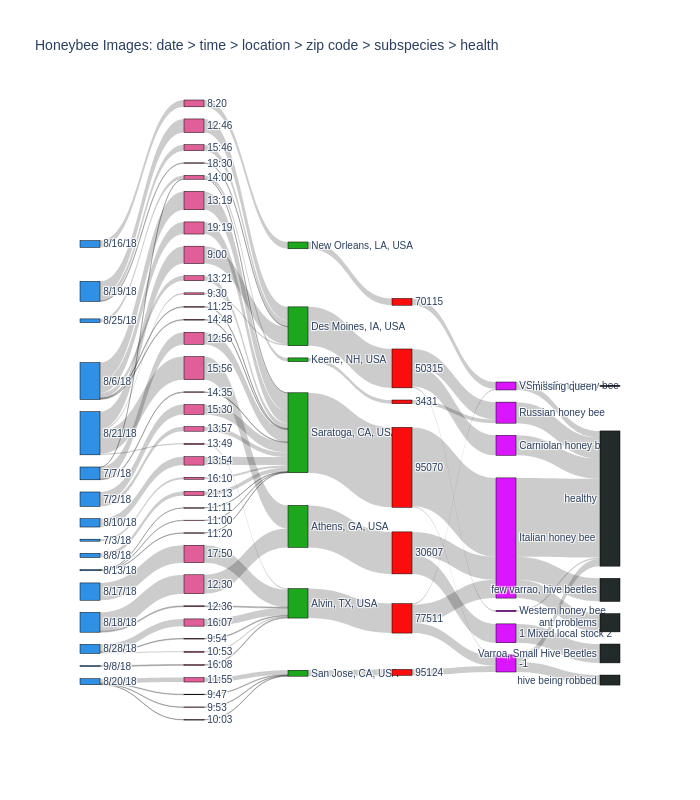

In [37]:
fig = plotly_sankey(df,cat_cols=['date', 'time', 'location', 'zip code', 'subspecies', 'health'],value_cols='Images',
                    title='Honeybee Images: date > time > location > zip code > subspecies > health', 
                    color_palette = px.colors.qualitative.Dark24,
           height=800)
iplot(fig, filename='Honeybee Images')

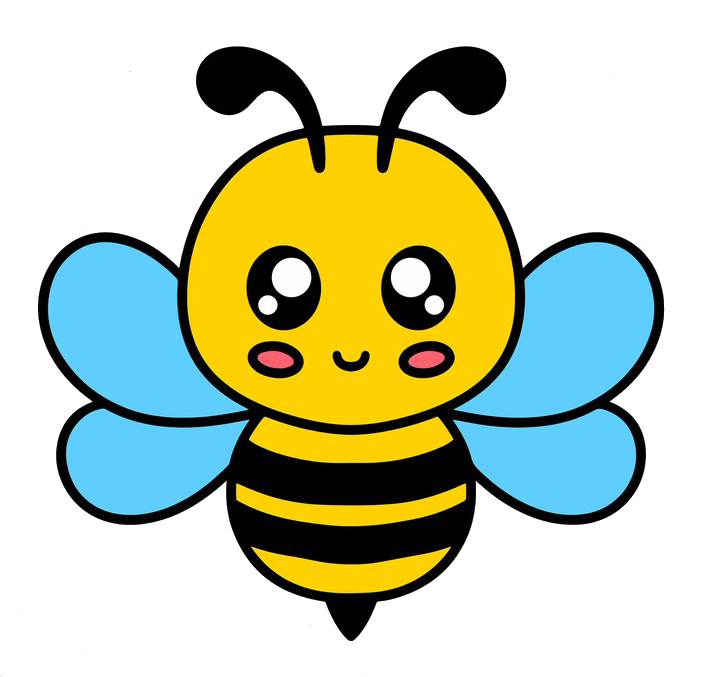

# <p id='3'>3. Finetuning</p>

Now, we are going to fine-tune the VGG-16 model on our dataset. The model is trained on ImageNet dataset. Fine-tuning the VGG16 model on our dataset combines the advantages of pre-trained model robustness, reduced training time and computational costs, improved accuracy, and better generalization. This downstreaming approach helps effectively classification of specialized image.

Before we start with the process, let's check if we are equipped with cuda. 

In [38]:
!nvidia-smi

Tue May 28 12:20:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              26W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
!nvidia-smi --query-gpu=memory.total,memory.used,memory.free --format=csv | column -t -s ','

memory.total [MiB]   memory.used [MiB]   memory.free [MiB]
16384 MiB            0 MiB               16276 MiB


In [40]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("CUDA is available 🚀" if device == "cuda" else "CUDA is not available 🐢")

CUDA is available 🚀


Before feeding our data into the model, we must prepare those to suitable. The labels in the health column should be mapped into numbers. 

In [41]:
honey_bee_df['health'] = honey_bee_df['health'].map({'healthy': 0,
                                 'few varrao, hive beetles': 1,
                                 'Varroa, Small Hive Beetles': 2,
                                 'ant problems': 3,
                                 'hive being robbed': 4,
                                 'missing queen': 5})

honey_bee_df["health"].value_counts()

health
0    3384
1     579
2     472
3     457
4     251
5      29
Name: count, dtype: int64

Since our dataset is quite small, we need to apply data augmentation. Data augmentation is a technique that artificially expands the size of a dataset by creating modified versions of images in the dataset. This has several important benefits:<br />
**Feature Diversity:** Data augmentation helps the model learn various features by presenting it with different versions of the same image.<br />
**Overfitting Prevention:** By providing more diverse training data, it reduces the risk of overfitting, where the model performs well on training data but poorly on new, unseen data.<br />
**Better Generalization:** It helps the model generalize better to new images, which is crucial for real-world applications.
>**NOTE:** As we saw before, some images with the same health problem/ subpecies have distinct background which are taken from a single hive.  Data augmentation may even partially help prevent the model from capturing background as feature related to those certain health problems and subspecies. 

In our scenario, we use the PyTorch library's transformation functions to implement data augmentation. Here’s how we do it:<br />
**RandomPerspective:** This transformation randomly changes the perspective of an image, making it appear as if it was taken from a different angle. This helps the model handle variations in camera angles.<br />
**RandomAutocontrast:** Set autocontrast with a probability of 0.5.<br />
**Resize:** Since our images have different sizes, we resize them to a uniform size of 264 pixels.<br />
**CenterCrop:** After resizing, we center crop the image to 224 pixels.
>**NOTE: **Although the median sizes of the images are smaller compared to our crop size(224), I think 224 is still a reasonable size for cropping since it is used by VGG16. 

**Normalization:** Finally, we normalize the images using the mean and standard deviation values from the VGG16 model configuration. This helps in speeding up the training process and achieving better convergence.<br />

I tried to use the following transformation techniques that make the training process harder for the model. This way the model can have a better grasp of features and promote generalization for the test on unseen data. 

In [42]:
transform = {
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.3, p=0.7),
#         transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
#         transforms.RandomRotation(degrees=(0, 45)),
        transforms.RandomAutocontrast(p=0.5),
        transforms.Resize(264),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


It's time to utilize PyTorch's Dataset class as a base to allow for easy integration with PyTorch's data loading utilities.We build our HoneyBeeDataset by inherenting the Dataset object of PyTorch.

In [43]:
class HoneyBeeData(Dataset):
    def __init__(self, honey_bee_df, image_path, transform=None):
        self.data = honey_bee_df
        self.root_dir = image_path
        self.labels = np.asarray(honey_bee_df['health'])
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        return (self.transform(Image.open(img_name).convert('RGB')) if self.transform 
                else Image.open(img_name).convert('RGB'), self.labels[idx])

In [44]:
honey_bee_ds = HoneyBeeData(honey_bee_df=honey_bee_df, image_path=path_config['image_path'])

In the following step, I'd like to split the data into training, validation and test sets. Because our dataset is pretty small, I want to specify 10% for each of the test and validation set.  The rest should be enought for our training purpose. 

In [45]:
validation_split, test_split = 0.1, 0.1
dataset_size = len(honey_bee_ds)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_size = int(validation_split * dataset_size)
test_size = int(test_split * dataset_size)
train_indices = indices[val_size + test_size:]
val_indices = indices[:val_size]
test_indices = indices[val_size:val_size + test_size]
len(train_indices), len(val_indices), len(test_indices)

(4138, 517, 517)

Now, it's time to define our dataloaders which enables efficient handling and processing of the data during model training and evaluation.

In [46]:
dataset_sizes = {'train': len(train_indices), 'val': len(val_indices), 'test': len(test_indices)}

datasets = {}
dataloaders = {}

for name, indices in zip(['train', 'val', 'test'], [train_indices, val_indices, test_indices]):
    datasets[name] = HoneyBeeData(honey_bee_df=honey_bee_df,
                                      image_path=path_config['image_path'],
                                      transform=transform[name])
    dataloaders[name] = torch.utils.data.DataLoader(datasets[name], batch_size=64, sampler=SubsetRandomSampler(indices))


The goal of finetuning is to leverage the pre-trained model VGG-16, and optimizing its parameters to achieve high accuracy on our dataset. This includes several steps. 

**Training Loop:** The function train_model takes several parameters including the model itself, loss function, optimizer, learning rate scheduler, and the number of epochs. It iterates through each epoch, performing training and validation steps.

**Model Initialization:** We initialize the model, in this case, a pre-trained VGG16. We freeze the parameters of the model to prevent them from being updated during training.

**Loss Function and Optimizer:** We define the loss function (nn.CrossEntropyLoss()) which computes the cross-entropy loss between the predicted and actual class labels. We also specify the optimizer (torch.optim.AdamW) which updates the model parameters based on the computed gradients. The optimizer has a learning rate of 1.4e-5 and a weight decay of 4.4e-1. 

**Learning Rate Scheduler:** The learning rate scheduler (torch.optim.lr_scheduler.StepLR) adjusts the learning rate during training. Here, it decreases the learning rate by a factor of 0.1 every epoch.

**Training Loop Details:** Within each epoch, the code iterates over the training and validation datasets. It calculates the loss, updates model parameters during the training phase, and evaluates performance metrics such as accuracy and F1-score on both training and validation datasets.

**Best Model Selection:** The best model weights are stored based on the validation accuracy achieved during training.

**Visualization:** After training, the function plots the training and validation loss curves using Plotly to visualize how the loss changes over epochs.

> One of the most important part of training/finetuning process is hyperparameter optimization. This should be done very carefully by adjusting each one and checking the output. Some people prefere to use Optuna hyperparameter optimization framework, but here I jsut found a good hypermarameter  manually. 

In [47]:
# fig.show(renderer='browser')

Epoch 0/15
Train Loss: 1.0265 | F1: 0.2084 | Acc: 0.6428
Val Loss: 0.6512 | F1: 0.4267 | Acc: 0.7621

Epoch 1/15
Train Loss: 0.5269 | F1: 0.5504 | Acc: 0.8173
Val Loss: 0.3613 | F1: 0.6726 | Acc: 0.8820

Epoch 2/15
Train Loss: 0.3476 | F1: 0.6518 | Acc: 0.8782
Val Loss: 0.2530 | F1: 0.6985 | Acc: 0.9072

Epoch 3/15
Train Loss: 0.2564 | F1: 0.7275 | Acc: 0.9120
Val Loss: 0.1795 | F1: 0.8630 | Acc: 0.9439

Epoch 4/15
Train Loss: 0.2026 | F1: 0.8170 | Acc: 0.9273
Val Loss: 0.1543 | F1: 0.8626 | Acc: 0.9439

Epoch 5/15
Train Loss: 0.1768 | F1: 0.8459 | Acc: 0.9355
Val Loss: 0.1361 | F1: 0.9074 | Acc: 0.9497

Epoch 6/15
Train Loss: 0.1460 | F1: 0.8724 | Acc: 0.9502
Val Loss: 0.1374 | F1: 0.8751 | Acc: 0.9439

Epoch 7/15
Train Loss: 0.1296 | F1: 0.8978 | Acc: 0.9565
Val Loss: 0.1289 | F1: 0.8843 | Acc: 0.9497

Epoch 8/15
Train Loss: 0.1072 | F1: 0.9240 | Acc: 0.9628
Val Loss: 0.1160 | F1: 0.8939 | Acc: 0.9555

Epoch 9/15
Train Loss: 0.1005 | F1: 0.9400 | Acc: 0.9681
Val Loss: 0.0993 | F1: 0.

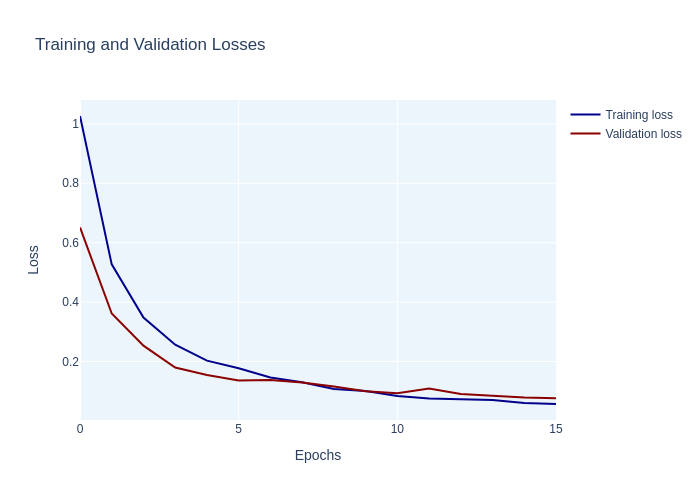

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_score = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0

    # Initialize lists to store loss values
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}\n{'=' * 20}")

        for phase in ['train', 'val']:
            model.train(phase == 'train')
            running_loss = 0.0
            running_corrects = 0

            all_labels = []
            all_preds = []

            for data in dataloaders[phase]:
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.max(outputs, 1)[1]
                running_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | F1: {epoch_f1:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_score = copy.deepcopy(model.state_dict())

            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1

        print()  # Newline for better readability between epochs

    print(f"Best val Acc: {best_acc:.4f}")
    print(f"Best val F1: {best_f1:.4f}")
    model.load_state_dict(best_model_score)

    # Plot the training and validation loss curves using Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=train_losses, mode='lines', name='Training loss', line=dict(color='darkblue')))
    fig.add_trace(go.Scatter(x=list(range(num_epochs)), y=val_losses, mode='lines', name='Validation loss', line=dict(color='darkred')))
    fig.update_layout(title='Training and Validation Losses', xaxis_title='Epochs', yaxis_title='Loss', plot_bgcolor='#ebf5fb')
    fig.show()

    return model

model_pre = models.vgg16(pretrained=True)

# Freeze pretrained model parameters
for param in model_pre.features.parameters():
    param.requires_grad = False

# Modify classifier
num_features = model_pre.classifier[6].in_features
model_pre.classifier[-1] = nn.Linear(num_features, 6)

# Load to device
model_pre = model_pre.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Define AdamW optimizer
optimizer = torch.optim.AdamW(model_pre.parameters(), lr=1.4e-5, weight_decay=4.4e-1, amsgrad=True)

# Decay LR by a factor of 0.1 every epoch
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
EPOCHS = 16

model_pre = train_model(model_pre, criterion, optimizer, scheduler, num_epochs=EPOCHS)

The above learning curve seems pretty decent. 

After training a deep learning model, it's crucial to thoroughly assess its performance on unseen data to ensure its effectiveness in real-world scenarios.

In [52]:
def test_model():
    true_labels, pred_labels = [], []
    running_correct = running_total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            true_labels.extend(labels.tolist())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs, 1)
            pred_labels.extend(preds.tolist())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()

    return true_labels, pred_labels, running_correct, running_total

true_labels, pred_labels, running_correct, running_total = test_model()
accuracy = accuracy_score(true_labels, pred_labels)
f1_macro = f1_score(true_labels, pred_labels, average='macro')

print(f'Correct: {running_correct}, Total: {running_total}, Test Accuracy: {accuracy:.2%}')
print(f'Macro-Averaged F1 Score: {f1_macro:.2f}')


Correct: 497, Total: 517, Test Accuracy: 96.13%
Macro-Averaged F1 Score: 0.88


The model achieved impressive results, with 96.32% accuracy and a macro-averaged F1 score of 0.88. This indicates that the model's predictions are accurate across various classes, showcasing its robustness and efficacy. With such high performance metrics, we can confidently conclude that the model has successfully learned meaningful patterns from the data and generalizes well to unseen examples.

# <p id='4'>4. Inference</p>

In [50]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Save the model
torch.save(model_pre.state_dict(), '/kaggle/working/bee_health_predictor.pth')

# Load the model
model_loaded = models.vgg16(pretrained=True)
num_features = model_loaded.classifier[6].in_features
features = list(model_loaded.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 6)])
model_loaded.classifier = nn.Sequential(*features) 
model_loaded.load_state_dict(torch.load('/kaggle/working/bee_health_predictor.pth'))
model_loaded.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

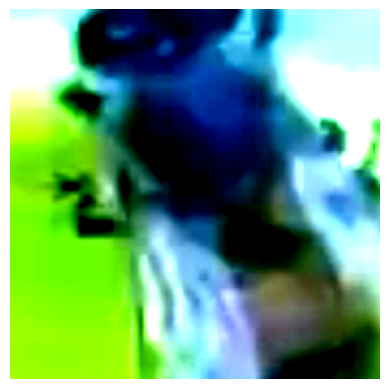

Actual label: hive being robbed
Predicted label: hive being robbed
Confidence level: 0.98


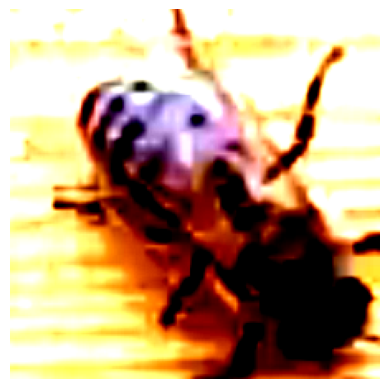

Actual label: ant problems
Predicted label: ant problems
Confidence level: 1.00


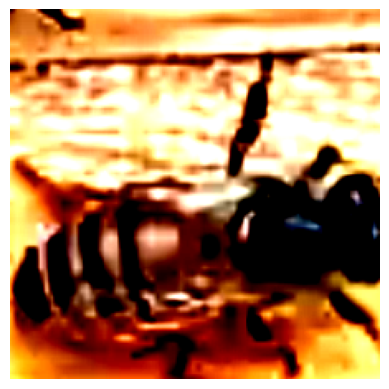

Actual label: ant problems
Predicted label: ant problems
Confidence level: 1.00


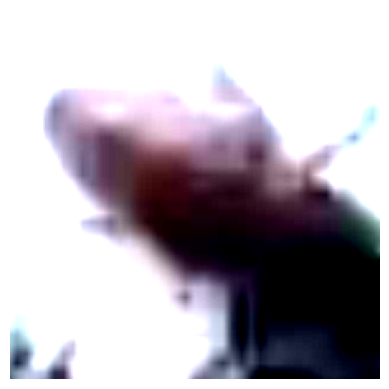

Actual label: healthy
Predicted label: healthy
Confidence level: 1.00


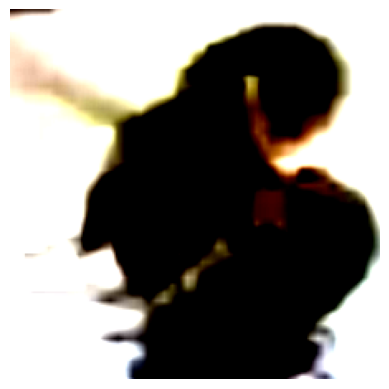

Actual label: healthy
Predicted label: healthy
Confidence level: 1.00


In [59]:
# Define class labels
classes = ['healthy', 'few varroa, hive beetles', 'Varroa, Small Hive Beetles', 'ant problems', 'hive being robbed', 'missing queen']

# Get a batch of test images and labels
images, labels = next(iter(dataloaders['test']))
random_indices = random.sample(range(len(images)), 5)

for idx in random_indices:
    # Convert the selected image to a numpy array and display it
    image = images[idx].permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Convert the image to a tensor and add batch dimension
    image_tensor = transforms.functional.to_tensor(image).unsqueeze(0)

    # Get prediction and confidence
    with torch.no_grad():
        output = model_loaded(image_tensor)
        predicted = output.argmax(1).item()
        confidence = torch.nn.functional.softmax(output, dim=1)[0][predicted].item()

    print(f'Actual label: {classes[labels[idx].item()]}\nPredicted label: {classes[predicted]}\nConfidence level: {confidence:.2f}')


Well done! We've got a decent model with good scores. It is recommended to promote the thrustworthiness of the model using explainability as the next steps. 

>NOTE: This exercise is still not complete... Some parts may change or being added. 

# REFERENCES:
https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html 

https://www.kaggle.com/datasets/jenny18/honey-bee-annotated-images

https://www.kaggle.com/code/gpreda/honey-bee-subspecies-classification 

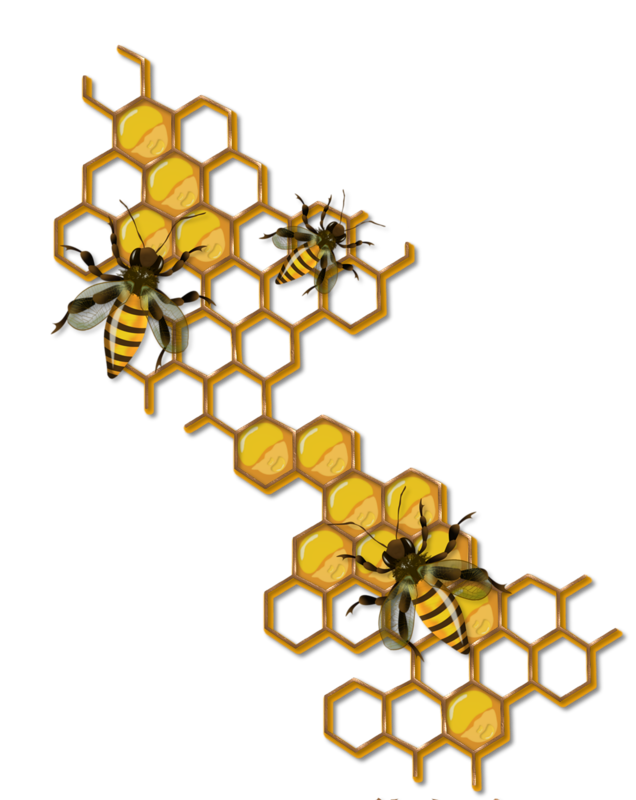